In [ ]:
import keras
import tensorflow as tf
!pip install Keras-Preprocessing
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load the dataset (replace with the actual file path)
data = pd.read_csv('Suicide_Detection.csv')

# Display basic info
print(data.head())
print(data['class'].value_counts())  # Check class distribution (suicide/not suicide)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


In [ ]:
# Function to clean the text (can be customized)
def clean_text(text):
    text = text.str.lower().str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation, lower case
    return text

# Apply text cleaning
data['cleaned_text'] = clean_text(data['text'])
# Apply text cleaning
data['cleaned_text'] = clean_text(data['text'])

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Initialize tokenizer with vocab size and OOV token
tokenizer.fit_on_texts(data['cleaned_text'])  # Fit on cleaned text
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences and pad them
max_len = 50
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)


In [ ]:
# Convert output to binary (1 for suicide, 0 for not suicide)
data['class'] = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

# Split data into train and test sets
train_text_pad, test_text_pad, train_output, test_output = train_test_split(
    padded_sequences, data['class'], test_size=0.2, random_state=10)

# Check class balance
print(pd.Series(train_output).value_counts())

class
1    92831
0    92828
Name: count, dtype: int64


In [ ]:
# Load GloVe embeddings
embedding_dict = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vectors

# Create an embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Build the model
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True))
model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 300)             │      68,437,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 64)              │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,548,137 (261.49 MB)

 Trainable params: 68,548,137 (261.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_output), y=train_output)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.000016158917568, 1: 0.9999838416046364}


In [ ]:
# Fit the model with class weights
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,min_delta=0.0001)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

In [ ]:
# Convert train_output and test_output indices to standard 0-based indexing
train_output = train_output.reset_index(drop=True)
test_output = test_output.reset_index(drop=True)

from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_labels = np.unique(train_output)
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=train_output)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

# Retrain the model with class weights
r = model.fit(
    train_text_pad,
    train_output,
    validation_data=(test_text_pad, test_output),
    epochs=20,
    batch_size=256,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reducelr]
)

Class Weights: {0: 1.000016158917568, 1: 0.9999838416046364}
Epoch 1/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.8558 - loss: 0.3287 - val_accuracy: 0.9246 - val_loss: 0.1943 - learning_rate: 0.0010
Epoch 2/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 108s 148ms/step - accuracy: 0.9301 - loss: 0.1815 - val_accuracy: 0.9294 - val_loss: 0.1821 - learning_rate: 0.0010
Epoch 3/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 108s 148ms/step - accuracy: 0.9394 - loss: 0.1579 - val_accuracy: 0.9307 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 4/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 143s 150ms/step - accuracy: 0.9474 - loss: 0.1413 - val_accuracy: 0.9300 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 5/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 140s 148ms/step - accuracy: 0.9535 - loss: 0.1248 - val_accuracy: 0.9284 - val_loss: 0.1899 - learning_rate: 0.0010
Epoch 6/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 143s 150ms/step - accuracy: 0.9627 - loss: 0.1048 - val_accuracy: 0.9295 - val_loss: 0.1981 - learning_rate: 1.0000e-04

In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_text_pad, test_output)
print(f'Test Accuracy: {test_acc}')

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9323 - loss: 0.1773
Test Accuracy: 0.9307336211204529


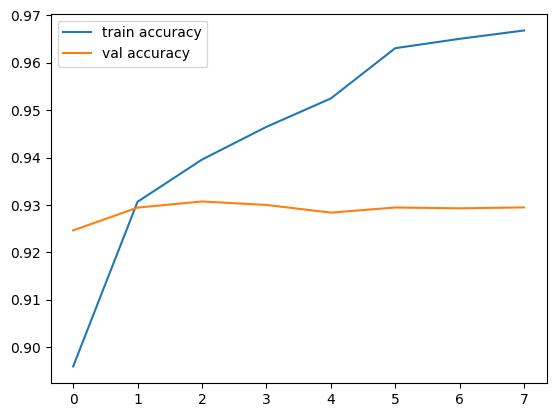

In [ ]:
# Plot training history
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()


In [ ]:
# Predict on the test set
y_pred = model.predict(test_text_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# Classification report for precision, recall, and F1 score
print(classification_report(test_output, y_pred, target_names=['Not Suicide', 'Suicide']))

# Confusion matrix (optional but useful)
cm = confusion_matrix(test_output, y_pred)
print("Confusion Matrix:\n", cm)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step
              precision    recall  f1-score   support

 Not Suicide       0.94      0.93      0.93     23209
     Suicide       0.93      0.94      0.93     23206

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

Confusion Matrix:
 [[21475  1734]
 [ 1481 21725]]


In [ ]:
def preprocess_input_sentence(sentence, tokenizer, max_len):
    # Clean the input sentence (same as what you did during training)
    sentence = clean_text(pd.Series([sentence]))  # Clean the input
    # Convert the sentence to a sequence of tokens
    sequence = tokenizer.texts_to_sequences(sentence)
    # Pad the sequence to match the max length
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

def predict_suicide_risk(sentence, model, tokenizer, max_len):
    # Preprocess the input sentence
    processed_sentence = preprocess_input_sentence(sentence, tokenizer, max_len)
    # Make the prediction (output will be a probability between 0 and 1)
    prediction = model.predict(processed_sentence)
    # Interpret the result
    if prediction > 0.5:
        print(f'This text indicates suicidal tendencies. (Confidence: {prediction[0][0]:.2f})')
    else:
        print(f'This text does not indicate suicidal tendencies. (Confidence: {prediction[0][0]:.2f})')


In [ ]:
# Example input sentence
input_sentence = "I feel like there's no point in continuing anymore."
# Call the function to make a prediction
predict_suicide_risk(input_sentence, model, tokenizer, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
This text indicates suicidal tendencies. (Confidence: 0.59)


In [ ]:
# Install IPyWidgets if not installed
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pickle

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Assuming you have your model and tokenizer ready
import os
import pickle
from tensorflow.keras.models import load_model

# Mount Google Drive (force remount in case of issues)
drive.mount("/content/drive", force_remount=True)

# Specify the folder where you want to save the model and tokenizer
model_folder = '/content/drive/My Drive/Model'  # Change this to your desired folder

# Create the folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

# Step 2: Save the Keras model (.h5 format)
model.save(os.path.join(model_folder, 'my_model.h5'))

# Step 3: Save the tokenizer as a .pkl file (Ensure no ellipsis)
with open(os.path.join(model_folder, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved successfully!")


Mounted at /content/drive


Mounted at /content/drive
Model and tokenizer saved successfully!


In [ ]:
# Load your trained model and tokenizer from Google Drive
model = load_model('/content/drive/My Drive/Model/my_model.h5')  # Update with your model's path

# Load tokenizer (from the .pkl file saved earlier)
with open('/content/drive/My Drive/Model/tokenizer.pkl', 'rb') as handle:  # Update with your tokenizer's path
    tokenizer = pickle.load(handle)

# Set the max_len (same as during training)
max_len = 50  # Modify according to your model's max sequence length

# Function to predict suicide risk (reuses the preprocessing function defined earlier)
def predict_suicide_risk(change):
    input_sentence = text_box.value.strip()  # Get text from input
    if input_sentence == "":
        result_label.value = "Please enter a sentence."
        return

    # Preprocess the input sentence using the previously defined function
    processed_sentence = preprocess_input_sentence(input_sentence, tokenizer, max_len)

    # Make prediction
    prediction = model.predict(processed_sentence)

    # Examine model predictions
    print(f'Raw prediction: {prediction[0][0]}')  # Print raw prediction value for debugging

    # Display the result
    if prediction > 0.5:  # Modify threshold based on your use case
        result_label.value = f'Suicidal tendencies detected (Confidence: {prediction[0][0]:.2f})'
    else:
        result_label.value = f'No suicidal tendencies detected (Confidence: {prediction[0][0]:.2f})'

# Create IPyWidgets components
text_box = widgets.Textarea(
    placeholder='Enter text to analyze',
    description='Input Text:',
    layout=widgets.Layout(width='80%', height='100px')
)

analyze_button = widgets.Button(
    description='Analyze',
    button_style='info'
)

result_label = widgets.Label(
    value='Prediction will appear here.'
)

# Set up event handler for the button click
analyze_button.on_click(predict_suicide_risk)

# Display the widgets
display(text_box, analyze_button, result_label)

Textarea(value='', description='Input Text:', layout=Layout(height='100px', width='80%'), placeholder='Enter t…

Button(button_style='info', description='Analyze', style=ButtonStyle())

Label(value='Prediction will appear here.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Raw prediction: 0.14462970197200775


In [ ]:
import pandas as pd


In [ ]:
print(data.columns)

Index(['Unnamed: 0', 'text', 'class', 'cleaned_text'], dtype='object')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Assuming 'text' column contains the input text and 'label' contains the binary labels
X = data['text']  # Reusing 'data' variable from earlier sections
y = data['class']

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limit the number of features for better performance
X_tfidf = tfidf.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)

# Train and evaluate Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Train and evaluate Logistic Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Train and evaluate Decision Tree Classifier
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Random Forest Accuracy: 0.8988258106215663
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     23287
           1       0.90      0.90      0.90     23128

    accuracy                           0.90     46415
   macro avg       0.90      0.90      0.90     46415
weighted avg       0.90      0.90      0.90     46415

Logistic Regression Accuracy: 0.9365722288053431
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     23287
           1       0.94      0.93      0.94     23128

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415

Decision Tree Accuracy: 0.8536249057416784
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     23287
           1       0.86      0.85      0.85     23128

    accuracy                           0.85    

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Assuming 'data' is already preprocessed from the previous section

# Tokenization and padding steps from previous NLP code
# Ensure data is processed the same way
X = padded_sequences
y = data['class']

# Split data into train and test sets (same as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Placeholder dictionary for results
results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}

# 1. LSTM-Based NLP Model (assuming it has already been trained)
y_pred_nlp = (model.predict(X_test) > 0.5).astype(int)

# LSTM metrics
accuracy_nlp = accuracy_score(y_test, y_pred_nlp)
f1_nlp = f1_score(y_test, y_pred_nlp)
precision_nlp = precision_score(y_test, y_pred_nlp)
recall_nlp = recall_score(y_test, y_pred_nlp)

# Store results for LSTM model
results['Model'].append('LSTM NLP Model')
results['Accuracy'].append(accuracy_nlp)
results['F1 Score'].append(f1_nlp)
results['Precision'].append(precision_nlp)
results['Recall'].append(recall_nlp)

# 2. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Logistic Regression metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)

# Store results for Logistic Regression
results['Model'].append('Logistic Regression')
results['Accuracy'].append(accuracy_lr)
results['F1 Score'].append(f1_lr)
results['Precision'].append(precision_lr)
results['Recall'].append(recall_lr)

# 3. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Decision Tree metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

# Store results for Decision Tree
results['Model'].append('Decision Tree')
results['Accuracy'].append(accuracy_dt)
results['F1 Score'].append(f1_dt)
results['Precision'].append(precision_dt)
results['Recall'].append(recall_dt)

# 4. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Random Forest metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Store results for Random Forest
results['Model'].append('Random Forest')
results['Accuracy'].append(accuracy_rf)
results['F1 Score'].append(f1_rf)
results['Precision'].append(precision_rf)
results['Recall'].append(recall_rf)

# Convert results dictionary into a DataFrame
results_df = pd.DataFrame(results)

# Display the final table of results
print(results_df)


1451/1451 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step
                 Model  Accuracy  F1 Score  Precision    Recall
0       LSTM NLP Model  0.930734  0.931105   0.926084  0.936180
1  Logistic Regression  0.668168  0.688105   0.649068  0.732138
2        Decision Tree  0.680728  0.681716   0.679570  0.683875
3        Random Forest  0.777486  0.784699   0.760015  0.811040
